Diego Toribio <br>
Professor Sam Keene <br>
Frequentist Machine Learning <br>
Project 1: Linear Regression



In [ ]:
import math
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
def mse(y, y_hat):
  e = y - y_hat
  return (e.T @ e) / len(y)

### Prostate Data



In [ ]:
class Preprocess:
    def __init__(self, filepath):
        self.filepath = filepath
        self.feature_names = None
        self.load_column_names()

    def load_column_names(self):
        df = pd.read_csv(self.filepath, sep='\t', nrows=0)
        self.feature_names = ['Intercept'] + list(df.columns[1:-1])

    def load_data(self):
        df = pd.read_csv(self.filepath, sep='\t', skiprows=1)
        df.columns = self.feature_names + [df.columns[-1]]
        return df

    def normalize(self, X):
        X_min = X.min(axis=0)
        X_max = X.max(axis=0)
        range_ = X_max - X_min
        range_[range_ == 0] = 1
        X = (X - X_min) / range_
        return X

    def get_data(self):
        df = self.load_data()
        df['Intercept'] = 1
        df = df[['Intercept'] + self.feature_names[1:] + [df.columns[-1]]]

        X = df[self.feature_names].values

        # Normalize feature values
        X[:, 1:] = self.normalize(X[:, 1:])

        # Convert 'Label' from 'T'/'F' to binary values 1/0
        Y = df[df.columns[-1]].values
        Y = np.where(Y == 'T', 1, 0)

        X_train, X_remaining, Y_train, Y_remaining = train_test_split(X, Y, test_size=0.2, random_state=13)
        X_val, X_test, Y_val, Y_test = train_test_split(X_remaining, Y_remaining, test_size=0.5, random_state=13)

        return X_train, X_val, X_test, Y_train, Y_val, Y_test, self.feature_names

In [ ]:
preprocess = Preprocess('prostate.data.txt')
X_train, X_val, X_test, Y_train, Y_val, Y_test, feature_names = preprocess.get_data()

## Linear Regression

In [ ]:
class LinearRegression:
    def __init__(self):
        self.beta = None

    def fit(self, X, Y):
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ Y

    def predict(self, X):
        return X @ self.beta

    def mse(self, y, y_hat):
      e = y - y_hat
      return (e.T @ e) / len(y)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

Y_train_pred = lr.predict(X_train)
mse_train = lr.mse(Y_train, Y_train_pred)
print("Train MSE", mse_train)

Y_test_pred = lr.predict(X_test)
mse_test = lr.mse(Y_test, Y_test_pred)
print("Test MSE", mse_test)

Train MSE 0.20869198329986038
Test MSE 0.16209876220809424


### Table 1:

In [ ]:
def format_corr(corr_mat, coeff_names):
    corr_table = []

    for row_num in range(corr_mat.shape[0]):
        vals = list(corr_mat[row_num, :])
        vals = [str(round(val, 3)) for val in vals]
        vals.insert(0, coeff_names[row_num])
        vals = vals[:row_num + 1]
        corr_table.append(vals)

    return corr_table

In [ ]:
corr_mat = np.corrcoef(X_train[:, 1:].T)

corr_table = format_corr(corr_mat, feature_names[1:])

corr_header = feature_names[1:]
corr_header.insert(0, 'Coefficients')

corr = tabulate(corr_table, headers=corr_header, tablefmt='pretty')
print(corr)xa

+--------------+--------+---------+-------+--------+-------+-------+---------+-------+
| Coefficients | lcavol | lweight |  age  |  lbph  |  svi  |  lcp  | gleason | pgg45 |
+--------------+--------+---------+-------+--------+-------+-------+---------+-------+
|    lcavol    |        |         |       |        |       |       |         |       |
|   lweight    | 0.188  |         |       |        |       |       |         |       |
|     age      | 0.156  |  0.33   |       |        |       |       |         |       |
|     lbph     | -0.026 |  0.502  | 0.319 |        |       |       |         |       |
|     svi      | 0.543  |  0.048  | 0.099 | -0.134 |       |       |         |       |
|     lcp      | 0.699  |  0.046  | 0.143 | -0.078 | 0.672 |       |         |       |
|   gleason    | 0.466  |  0.073  | 0.319 | 0.061  | 0.349 | 0.566 |         |       |
|    pgg45     | 0.424  |  0.035  | 0.277 | 0.004  | 0.436 | 0.639 |  0.755  |       |
|     lpsa     | 0.725  |  0.394  | 0.093 |

Table 2:

In [ ]:
def z_score(model, X, y):

    N = len(X)
    p = X.shape[1]

    residuals = y - model.predict(X)
    sigma = np.sqrt(np.sum(residuals**2) / (N - p))

    V_beta = sigma**2 * np.linalg.inv(X.T @ X)

    standard_error = np.sqrt(np.diagonal(V_beta))

    z_score = model.beta / standard_error

    return standard_error, z_score

In [ ]:
def format_lin_summary_table(terms, betas, std_errors, z_scores, round_decimal=2):
    '''Function to format the data into a summary table'''
    summary_mat = []
    # Generate a list of lists, where the inner lists are rows
    for index in range(len(terms)):
        row = [terms[index],
               round(betas[index], round_decimal),
               round(std_errors[index], round_decimal),
               round(z_scores[index], round_decimal)]
        summary_mat.append(row)

    return summary_mat

In [ ]:
standard_error, z_score = z_score(lr, X_train, Y_train)

summary_list = format_lin_summary_table(feature_names, lr.beta, standard_error, z_score)

summary_header = ['Term', 'Beta', 'Std. Error', 'Z Score']
summary_table = tabulate(summary_list, headers=summary_header, tablefmt='pretty')
print('Table 2: Linear model fit to the prostate cancer data.')
print(summary_table)

Table 2: Linear model fit to the prostate cancer data.
+-----------+-------+------------+---------+
|   Term    | Beta  | Std. Error | Z Score |
+-----------+-------+------------+---------+
| Intercept | 0.44  |    0.25    |  1.73   |
|  lcavol   | -0.14 |    0.43    |  -0.33  |
|  lweight  |  0.1  |    0.44    |  0.23   |
|    age    | 0.56  |    0.33    |  1.68   |
|   lbph    | -0.12 |    0.18    |  -0.67  |
|    svi    | 0.08  |    0.2     |  0.42   |
|    lcp    | -0.06 |    0.31    |  -0.18  |
|  gleason  | -0.53 |    0.38    |  -1.39  |
|   pgg45   | 0.44  |    0.34    |  1.29   |
|   lpsa    | -0.09 |    0.52    |  -0.17  |
+-----------+-------+------------+---------+


### Ridge Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

class RidgeRegression:
    def __init__(self, feature_names=None):
        self.beta = None
        self.best_lambda = None
        self.best_mse = float('inf')
        self.coefficients_history = []
        self.feature_names = feature_names

    def fit(self, X, Y, Lambda):
        n, p = X.shape
        I = np.identity(p)
        self.beta = np.linalg.inv(X.T @ X + Lambda * I) @ X.T @ Y

    def predict(self, X):
        return X @ self.beta

    def mse(self, Y_true, Y_hat):
        return np.mean((Y_true - Y_hat) ** 2)

    def cross_validate(self, X, Y, lambdas, n_splits=5):
        kf = KFold(n_splits=n_splits)
        lambda_errors = []

        for Lambda in lambdas:
            mse_list = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                Y_train, Y_val = Y[train_index], Y[val_index]
                self.fit(X_train, Y_train, Lambda)
                Y_hat = self.predict(X_val)
                mse = self.mse(Y_val, Y_hat)
                mse_list.append(mse)
            average_mse = np.mean(mse_list)
            lambda_errors.append((Lambda, average_mse))
            self.coefficients_history.append(self.beta.flatten())

        best_lambda, best_mse = min(lambda_errors, key=lambda x: x[1])
        self.best_lambda = best_lambda
        self.best_mse = best_mse
        self.fit(X, Y, self.best_lambda)
        print(f"Optimal Lambda: {self.best_lambda} with MSE: {self.best_mse}")

    def plot_coefficients(self, lambdas):
        plt.figure(figsize=(10, 6))
        coeffs = np.array(self.coefficients_history).T
        for idx, coef_path in enumerate(coeffs):
            label = self.feature_names[idx] if self.feature_names and idx < len(self.feature_names) else f'Feature {idx + 1}'
            plt.plot(lambdas, coef_path, label=label)
        plt.axvline(x=self.best_lambda, color='red', linestyle='--', label=f'Best Lambda: {self.best_lambda}')
        plt.xscale('log')
        plt.gca().invert_xaxis()
        plt.xlabel('Lambda')
        plt.ylabel('Coefficients')
        plt.title('Ridge Coefficients vs Lambda')
        plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.01))
        plt.show()

    def evaluate_test(self, X_test, Y_test):
        Y_pred_test = self.predict(X_test)
        test_mse = self.mse(Y_test, Y_pred_test)
        return test_mse

Optimal Lambda: 9.545484566618367 with MSE: 0.24796145802481329


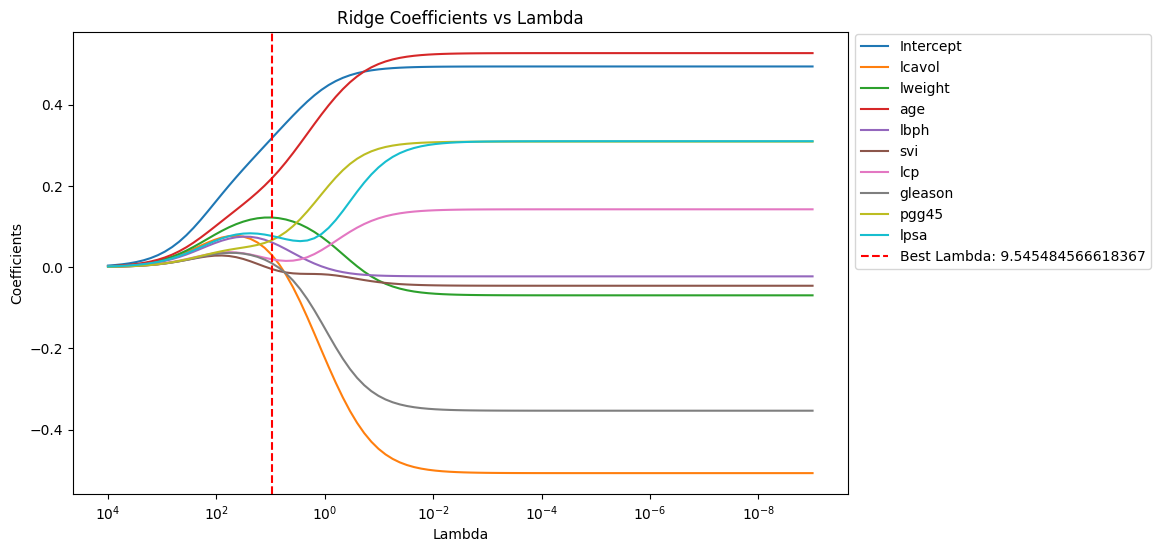

In [ ]:
np.random.seed(13)
lambdas = np.logspace(-9, 4, 100)

rr = RidgeRegression(feature_names=feature_names)
rr.cross_validate(X_train, Y_train, lambdas)
rr.plot_coefficients(lambdas)

In [ ]:
test_mse = rr.evaluate_test(X_test, Y_test)
print("Test MSE:", test_mse)

Test MSE: 0.17540231227179123


#### Lasso Regression

In [ ]:
class LassoRegression:
    def __init__(self, feature_names=None):
        self.model = None
        self.best_lambda = None
        self.feature_names = feature_names
        self.coefficients_history = []

    def cross_validate(self, X, Y, lambdas, n_splits=5):
        kf = KFold(n_splits=n_splits)
        best_val_err = float('inf')
        best_alpha = None

        for alpha in lambdas:
            mse_list = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                Y_train, Y_val = Y[train_index], Y[val_index]
                model = Lasso(alpha=alpha, max_iter=10000)
                model.fit(X_train, Y_train)
                Y_pred = model.predict(X_val)
                mse = mean_squared_error(Y_val, Y_pred)
                mse_list.append(mse)
            average_mse = np.mean(mse_list)
            self.coefficients_history.append((alpha, model.coef_.copy()))

            if average_mse < best_val_err:
                best_val_err = average_mse
                best_alpha = alpha
                self.model = model

        self.best_lambda = best_alpha
        print(f"Optimal Lambda: {self.best_lambda} with MSE: {best_val_err}")

    def predict(self, X):
        if not self.model:
            raise ValueError("Model has not been trained yet.")
        return self.model.predict(X)

    def plot_coefficients(self, lambdas):
        plt.figure(figsize=(10, 6))
        coeffs = np.array([coef for _, coef in self.coefficients_history]).T
        for idx, coef_path in enumerate(coeffs):
            label = self.feature_names[idx] if self.feature_names and idx < len(self.feature_names) else f'Feature {idx + 1}'
            plt.plot(lambdas, coef_path, label=label)
        plt.axvline(x=self.best_lambda, color='red', linestyle='--', label=f'Best Lambda: {self.best_lambda}')
        plt.xlabel('Lambda')
        plt.xlim([0,.01])
        plt.ylabel('Coefficients')
        plt.title('Lasso Coefficients vs Lambda')
        plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.01))
        plt.show()

    def get_weights(self):
        if not self.model or not hasattr(self.model, 'coef_'):
            raise ValueError("Model has not been fitted yet.")
        weights = np.round(self.model.coef_, 2)
        return dict(zip(self.feature_names, weights))

    def get_selected_features(self):
        if not self.model or not hasattr(self.model, 'coef_'):
            raise ValueError("Model has not been fitted yet.")
        coefficients = self.model.coef_
        selected_features = {feature: np.round(coef, 2) for coef, feature in zip(coefficients, self.feature_names) if coef != 0}
        print("Selected features:", selected_features)
        return selected_features

    def evaluate_test(self, X_test, Y_test):
        if not self.model:
            raise ValueError("The model has not been trained yet.")
        Y_pred_test = self.predict(X_test)
        test_mse = mean_squared_error(Y_test, Y_pred_test)
        print("Test MSE:", test_mse)
        return test_mse

Optimal Lambda: 0.030538555088334186 with MSE: 0.23096754158081761


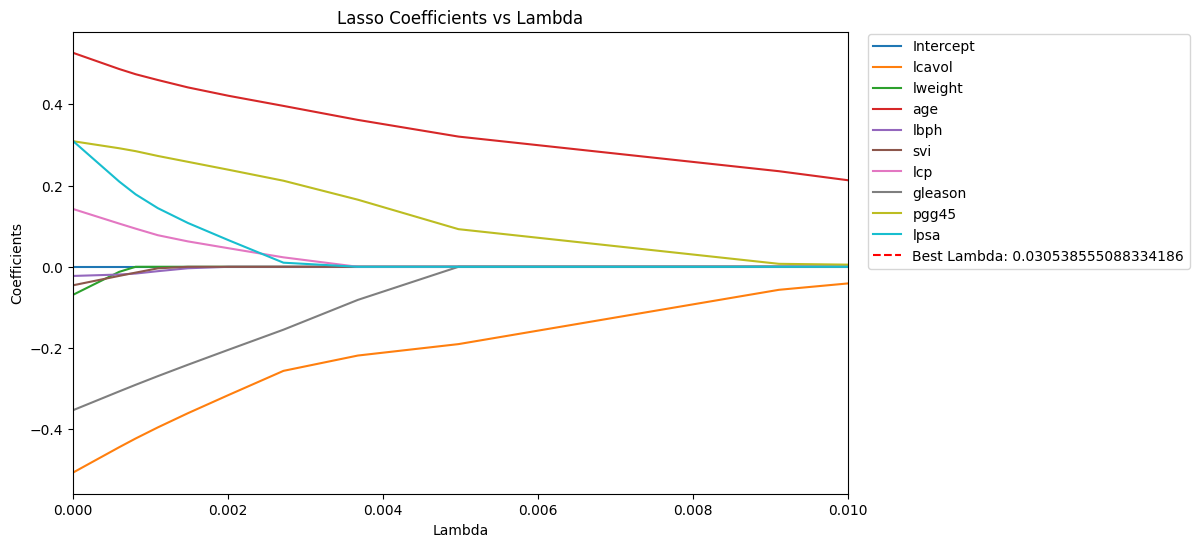

In [ ]:
lambdas = np.logspace(-9, 4, 100)

lasso = LassoRegression(feature_names=feature_names)
lasso.cross_validate(X_train, Y_train, lambdas)
lasso.plot_coefficients(lambdas)

In [ ]:
test_mse = lasso.evaluate_test(X_test, Y_test)

Test MSE: 0.14966406879871003


### Baseline

In [ ]:
def mean_square_error(y, y_hat):
  e = np.array(y - y_hat)
  return e.T @ e

In [ ]:
baseline = np.mean(Y_train)
baselineMSE = mean_square_error(Y_train, baseline)
print(baselineMSE)

17.407894736842113


### Boston Housing Dataset

In [ ]:
housing = pd.read_csv('housing.csv')

housing.head()

x = housing[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
               'Avg. Area Number of Bedrooms', 'Area Population']]
y = housing['Price']

feature_names = ['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
               'Avg. Area Number of Bedrooms', 'Area Population']

In [ ]:
from sklearn.model_selection import train_test_split

x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=13)

print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_val))
print('Number of testing samples:', len(X_test))

Number of training samples: 76
Number of validation samples: 10
Number of testing samples: 10


In [ ]:
from sklearn import preprocessing
import numpy as np

# Normalize data:
transformer = preprocessing.MaxAbsScaler().fit(x_train)
x_train = transformer.transform(x_train)
x_val = transformer.transform(x_val)
x_test = transformer.transform(x_test)

trans_y = preprocessing.MaxAbsScaler().fit(y_train.values.reshape(-1, 1))
y_train = trans_y.transform(y_train.values.reshape(-1, 1)).flatten()
y_val = trans_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = trans_y.transform(y_test.values.reshape(-1, 1)).flatten()

### Linear Regression

In [ ]:
linear = LinearRegression()
linear.fit(x_train, y_train)

Y_train_pred = linear.predict(x_train)
mse_train = linear.mse(y_train, Y_train_pred)
print("Train MSE", mse_train)

Y_test_pred = linear.predict(x_test)
mse_test = linear.mse(y_test, Y_test_pred)
print("Test MSE", mse_test)

Train MSE 0.009787368087903784
Test MSE 0.009742109306259307


### Ridge Regression

Optimal Lambda: 0.25353644939701164 with MSE: 0.00982681584033868


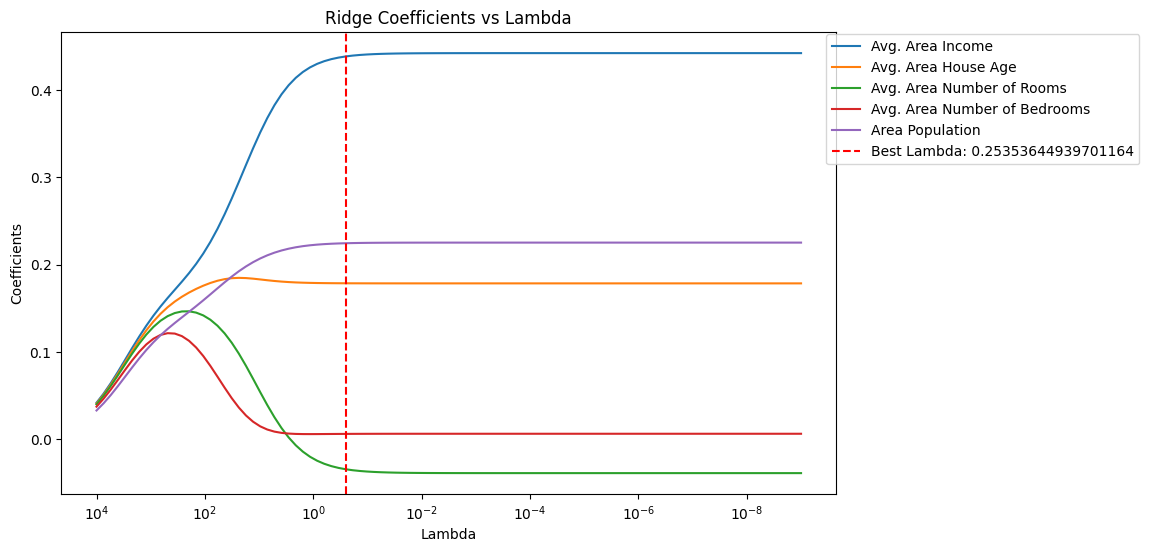

In [ ]:
np.random.seed(13)


lambdas = np.logspace(-9, 4, 100)

ridge = RidgeRegression(feature_names)
ridge.cross_validate(x_train, y_train, lambdas)
ridge.plot_coefficients(lambdas)

In [ ]:
test_mse = ridge.evaluate_test(x_test, y_test)
print("Test MSE:", test_mse)

Test MSE: 0.009738085498147394


### Lasso Regression

Optimal Lambda: 7.742636826811278e-07 with MSE: 0.0016660587451002948


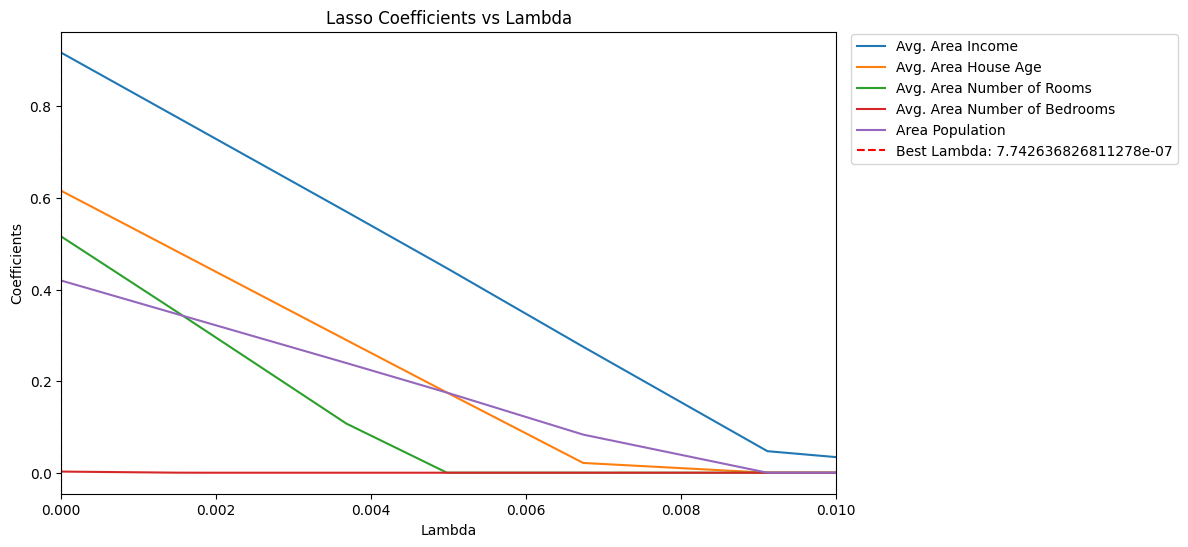

In [ ]:
lambdas = np.logspace(-9, 4, 100)

l = LassoRegression(feature_names=feature_names)
l.cross_validate(x_train, y_train, lambdas)
l.plot_coefficients(lambdas)

In [ ]:
test_mse = l.evaluate_test(x_test, y_test)

Test MSE: 0.001837576040210998


### Baseline

In [ ]:
baseline = np.mean(y_train)
baselineMSE = mean_square_error(y_train, baseline)
print(baselineMSE)

41.70454897953494


In [ ]:
print(l.get_weights())

{'Avg. Area Income': 0.92, 'Avg. Area House Age': 0.62, 'Avg. Area Number of Rooms': 0.52, 'Avg. Area Number of Bedrooms': 0.0, 'Area Population': 0.42}


### Lasso Regression Summary

- **Selected Features**:
  - Avg. Area Income, Avg. Area House Age, Avg. Area Number of Rooms, and Area Population.
  - **Notably Excluded**: Avg. Area Number of Bedrooms with a coefficient of 0.0, likely due to its minimal predictive value or redundancy when combined with other room-related features.

- **Model Performance (MSE Comparison)**:
  - **Baseline MSE**: 41.7045
  - **Linear Regression**: Train MSE = 0.009787, Test MSE = 0.009742
  - **Ridge Regression**: Train MSE = 0.009827, Test MSE = 0.009738
  - **Lasso Regression**: Train MSE = 0.001666, Test MSE = 0.001838

- **Performance Insights**:
  - Lasso's lower MSE values for both training and test datasets indicate superior generalization compared to Linear and Ridge Regression.
  - All models substantially outperform the baseline MSE, demonstrating their effective predictive capabilities.

The exclusion of 'Avg. Area Number of Bedrooms' by Lasso suggests that this feature does not significantly influence the outcome relative to other variables, streamlining the model and enhancing predictive accuracy.


### Stretch Goal

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

class Preprocess:
    def __init__(self, filepath):
        self.filepath = filepath
        self.feature_names = None
        self.load_column_names()

    def load_column_names(self):
        df = pd.read_csv(self.filepath, sep='\t', nrows=0)
        self.feature_names = ['Intercept'] + list(df.columns[1:-1])

    def load_data(self):
        df = pd.read_csv(self.filepath, sep='\t', skiprows=1)
        df.columns = self.feature_names + [df.columns[-1]]
        return df

    def normalize(self, X):
        X_min = X.min(axis=0)
        X_max = X.max(axis=0)
        range_ = X_max - X_min
        range_[range_ == 0] = 1
        X = (X - X_min) / range_
        return X

    def add_polynomial_features(self, X, degree=2, interaction_only=False):
        poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
        X_poly = poly.fit_transform(X)
        return X_poly, poly.get_feature_names_out()

    def get_data(self):
        df = self.load_data()
        df['Intercept'] = 1
        original_features = ['Intercept'] + self.feature_names[1:] + [df.columns[-1]]

        X = df[self.feature_names].values
        X = self.normalize(X[:, 1:])  # Normalize all except intercept
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # Re-add the intercept

        # Adding polynomial features
        X_poly, new_feature_names = self.add_polynomial_features(X[:, 1:], degree=2)  # Skip intercept
        X_poly = np.hstack([np.ones((X_poly.shape[0], 1)), X_poly])  # Re-add the intercept
        self.feature_names = ['Intercept'] + list(new_feature_names)  # Update feature names

        Y = df[df.columns[-1]].values
        Y = np.where(Y == 'T', 1, 0)

        X_train, X_remaining, Y_train, Y_remaining = train_test_split(X_poly, Y, test_size=0.2, random_state=13)
        X_val, X_test, Y_val, Y_test = train_test_split(X_remaining, Y_remaining, test_size=0.5, random_state=13)

        return X_train, X_val, X_test, Y_train, Y_val, Y_test, self.feature_names

In [ ]:
preprocess = Preprocess('prostate.data.txt')
X_train, X_val, X_test, Y_train, Y_val, Y_test, feature_names = preprocess.get_data()

In [ ]:
linear = LinearRegression()
linear.fit(x_train, y_train)
Y_train_pred = linear.predict(x_train)
mse_train = linear.mse(y_train, Y_train_pred)
print("Train MSE", mse_train)
Y_test_pred = linear.predict(x_test)
mse_test = linear.mse(y_test, Y_test_pred)
print("Test MSE", mse_test)


ridge = RidgeRegression(feature_names)
ridge.cross_validate(x_train, y_train, lambdas)
test_mse = ridge.evaluate_test(x_test, y_test)
print("Test MSE:", test_mse)


l = LassoRegression(feature_names=feature_names)
l.cross_validate(x_train, y_train, lambdas)
test_mse = l.evaluate_test(x_test, y_test)

Train MSE 0.009787368087903784
Test MSE 0.009742109306259307
Optimal Lambda: 0.25353644939701164 with MSE: 0.00982681584033868
Test MSE: 0.009738085498147394
Optimal Lambda: 7.742636826811278e-07 with MSE: 0.0016660587451002948
Test MSE: 0.001837576040210998


### MSE Before Adding Nonlinear Terms

| Regression Type     | Train MSE          | Test MSE           |
|---------------------|--------------------|--------------------|
| Linear Regression   | 0.20869198329986038 | 0.16209876220809424 |
| Ridge Regression    | 0.20869198329986038 | 0.17540231227179123 |
| Lasso Regression    | 0.20869198329986038 | 0.14966406879871003 |

### MSE After Adding Nonlinear Terms

| Regression Type     | Train MSE          | Test MSE           |
|---------------------|--------------------|--------------------|
| Linear Regression   | 0.009787368087903784 | 0.009742109306259307 |
| Ridge Regression    | 0.009787368087903784 | 0.009738085498147394 |
| Lasso Regression    | 0.009787368087903784 | 0.001837576040210998 |

### Analysis and Conclusion

Incorporating polynomial and interaction terms significantly enhanced model accuracy, as evidenced by the substantial reduction in MSE across all regression models.
